In [813]:
#necessary libraries
import pandas as pd
import os
import numpy as np
import tensorflow as tf

In [814]:
#import dataset
moviesDataset=pd.read_csv(os.path.join(os.path.dirname('__file__'), "movie_metadata.csv"))
moviesDataset

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0
5,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,...,738.0,English,USA,PG-13,263700000.0,2012.0,632.0,6.6,2.35,24000
6,Color,Sam Raimi,392.0,156.0,0.0,4000.0,James Franco,24000.0,336530303.0,Action|Adventure|Romance,...,1902.0,English,USA,PG-13,258000000.0,2007.0,11000.0,6.2,2.35,0
7,Color,Nathan Greno,324.0,100.0,15.0,284.0,Donna Murphy,799.0,200807262.0,Adventure|Animation|Comedy|Family|Fantasy|Musi...,...,387.0,English,USA,PG,260000000.0,2010.0,553.0,7.8,1.85,29000
8,Color,Joss Whedon,635.0,141.0,0.0,19000.0,Robert Downey Jr.,26000.0,458991599.0,Action|Adventure|Sci-Fi,...,1117.0,English,USA,PG-13,250000000.0,2015.0,21000.0,7.5,2.35,118000
9,Color,David Yates,375.0,153.0,282.0,10000.0,Daniel Radcliffe,25000.0,301956980.0,Adventure|Family|Fantasy|Mystery,...,973.0,English,UK,PG,250000000.0,2009.0,11000.0,7.5,2.35,10000


In [815]:
#drop rows where gross and budget elements are null due to the fact that our target column will be derived from these two columns 
test = moviesDataset[moviesDataset.gross.notnull()]

In [816]:
test = test[test.budget.notnull()]

In [817]:
#split the monvie categories and convert them as dummies 
cleaned = test.set_index('movie_title').genres.str.split('|', expand=True).stack()
cleaned

movie_title                                 
Avatar                                     0         Action
                                           1      Adventure
                                           2        Fantasy
                                           3         Sci-Fi
Pirates of the Caribbean: At World's End   0         Action
                                           1      Adventure
                                           2        Fantasy
Spectre                                    0         Action
                                           1      Adventure
                                           2       Thriller
The Dark Knight Rises                      0         Action
                                           1       Thriller
John Carter                                0         Action
                                           1      Adventure
                                           2         Sci-Fi
Spider-Man 3                               0         Ac

In [818]:
splitGenres = pd.get_dummies(cleaned, prefix='g').groupby(level=0).sum()
splitGenres['index1'] = splitGenres.index

In [819]:
#merge the initial dataset with the above-created columns
test2=pd.merge(test, splitGenres, left_on = 'movie_title', right_on = 'index1')

In [820]:
#drop the columns index1 and genre
test2=test2.drop(['index1', 'genres'], axis = 1)

In [821]:
#fill NAs of continuous variables with zeroes and the categorical ones with dots
test3 = test2.apply(lambda x: x.fillna(0) if x.dtype.kind in 'biufc' else x.fillna('.'))

In [822]:
#create our dependent column (Y)
test3['blockbuster'] = 0

In [823]:
#find the gross margin so as to classify our entries as blockbuster or not
test3['grossMargin'] = test3['gross']/(test3['budget'] + test3['gross'])

In [824]:
#if gross margin is larger than the threshold=0.7 is considered as blockbuster
test3.loc[test3['grossMargin'] < 0.7, 'blockbuster'] = 0
test3.loc[test3['grossMargin'] >= 0.7, 'blockbuster'] = 1

In [825]:
#drop movie_imdb_link and grossMargin columns
test3 = test3.drop(['movie_imdb_link', 'grossMargin'], axis = 1)

In [826]:
#SET random seed to get the same random results every time for tf AND np
npRandom = np.random.seed(seed=12345)
tfRandom = tf.set_random_seed(1)

In [827]:
#split train and test sets
npRandom
msk= np.random.rand(len(test3)) < 0.8

In [828]:
train_dataset = test3[msk]

In [829]:
test_dataset = test3[~msk]

In [830]:
#split the x and y for the train set
x_train = train_dataset.drop('blockbuster', axis=1)
y_train = train_dataset.blockbuster

In [831]:
#use categorical processor in order to convert the catergorical variables in an integer
#form that could be manipulated by tensorflow
from tensorflow.contrib import learn as skflow
cat_processor = skflow.preprocessing.CategoricalProcessor()
x_train = np.array(list(cat_processor.fit_transform(x_train)))
x_train

array([[   1,    1,    1, ...,    1,    1,    1],
       [   1,    2,    2, ...,    2,    1,    1],
       [   1,    3,    3, ...,    2,    1,    1],
       ..., 
       [   1,  360,  344, ...,    2,    1,    1],
       [   1, 1284,  481, ...,    1,    1,    1],
       [   1, 1338,  376, ...,    1,    1,    1]], dtype=int64)

In [832]:
#convert to numpy array
y_train=y_train.values
y_train

array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

In [833]:
#split to x and y for test set
x_test = test_dataset.drop('blockbuster', axis=1)
y_test = test_dataset.blockbuster

In [834]:
#convert the categorical to integers
x_test = np.array(list(cat_processor.transform(x_test)))

In [835]:
#convert to numpy array
y_test=y_test.values
y_test

array([1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0,

In [836]:
from __future__ import print_function
from tensorflow.python.framework import ops


In [837]:
ops.reset_default_graph()

# Create graph
sess = tf.Session()

In [838]:
# Parameters
learning_rate = 0.01
training_epochs = 10
batch_size = 100
display_step = 1

# Network Parameters
n_hidden_1 = 256 # 1st layer number of features
n_hidden_2 = 256 # 2nd layer number of features
n_input = 49
n_classes = 1 
STDDEV = 0.1

In [839]:
print("Number of predictors \t%s" %(n_input))
print("Number of classes \t%s" %(n_classes))


Number of predictors 	49
Number of classes 	1


In [840]:
# tf Graph input
x_data = tf.placeholder(shape=[None, 49], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)
dropout_keep_prob = tf.placeholder(tf.float32)


In [841]:
#declare weights and biases
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1],stddev=STDDEV, seed=5)),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2],stddev=STDDEV, seed=5)),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes],stddev=STDDEV, seed=5)),                                   
}

biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1], seed=5)),
    'b2': tf.Variable(tf.random_normal([n_hidden_2], seed=5)),
    'out': tf.Variable(tf.random_normal([n_classes], seed=5))
}

In [842]:
#declare multilayer perceptron
def multilayer_perceptron(x, weights, biases):
    # Hidden layer with TANH activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.tanh(layer_1)
    # Hidden layer with TANH activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.tanh(layer_2)
    # Output layer with linear activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

# Construct model
prediction = multilayer_perceptron(x_data, weights, biases)
# Test model
#predictions_correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y_target, 1))
# Calculate accuracy
#accuracy = tf.nn.l2_loss(prediction-y_test,name="squared_error_test_cost")/x_test.shape[0]

predicted_class = tf.greater(prediction,0.7)
correct = tf.equal(predicted_class, tf.equal(y_target,1.0))
accuracy = tf.reduce_mean( tf.cast(correct, 'float') )

In [843]:
# Define loss and optimizer
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = prediction, labels = y_target))
my_opt = tf.train.AdamOptimizer()
train_step = my_opt.minimize(loss)

In [844]:
# Initializing the variables
init = tf.global_variables_initializer()
sess.run(init)

In [845]:
#Run graph
loss_vec = []
epochs = []
train_acc = []
test_acc = []
for epoch in range(training_epochs):
    avg_cost = 0.
    np.random.seed(seed=666)
    rand_index = np.random.choice(len(x_train), size=batch_size)
    rand_x = x_train[rand_index]
    rand_y = np.transpose([y_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})

    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)
    temp_acc_train = accuracy.eval({x_data: x_train, y_target: np.transpose([y_train])},session=sess)
    train_acc.append(temp_acc_train)
    temp_acc_test = accuracy.eval({x_data: x_test, y_target: np.transpose([y_test])},session=sess)
    test_acc.append(temp_acc_test)
    if (epoch+1)%display_step==0:
        print('Epoch:' +str('%04d' % (epoch+1))+ 
              ' Loss = ' + str(temp_loss),'train acc = '+ str(temp_acc_train),'test_acc='+ str(temp_acc_test))


Epoch:0001 Loss = 3.72528 train acc = 0.230819 test_acc=0.262887
Epoch:0002 Loss = 2.12131 train acc = 0.230819 test_acc=0.262887
Epoch:0003 Loss = 0.913687 train acc = 0.595506 test_acc=0.264175
Epoch:0004 Loss = 0.542466 train acc = 0.753451 test_acc=0.266753
Epoch:0005 Loss = 0.704829 train acc = 0.765008 test_acc=0.268041
Epoch:0006 Loss = 0.89924 train acc = 0.766613 test_acc=0.26933
Epoch:0007 Loss = 1.02393 train acc = 0.767897 test_acc=0.271907
Epoch:0008 Loss = 1.08284 train acc = 0.768218 test_acc=0.271907
Epoch:0009 Loss = 1.08593 train acc = 0.768218 test_acc=0.274485
Epoch:0010 Loss = 1.0542 train acc = 0.768218 test_acc=0.277062


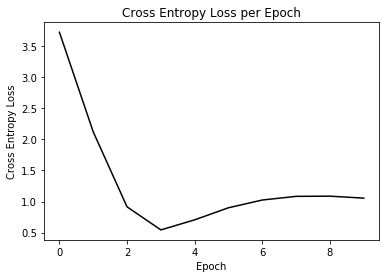

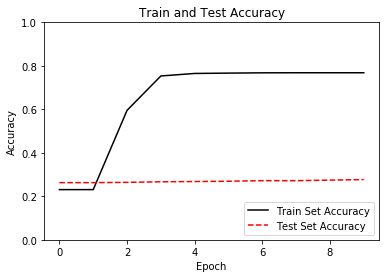

In [846]:
import matplotlib.pyplot as plt
import pylab


# Plot loss over time
plt.plot(loss_vec, 'k-')
plt.title('Cross Entropy Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.show()

# Plot train and test accuracy
pylab.ylim([0,1])
plt.plot(train_acc, 'k-', label='Train Set Accuracy')
plt.plot(test_acc, 'r--', label='Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [847]:
sess.run([x_data, weights], feed_dict={x_data: rand_x, y_target: rand_y});

In [848]:
weights

{'h1': <tf.Variable 'Variable:0' shape=(49, 256) dtype=float32_ref>,
 'h2': <tf.Variable 'Variable_1:0' shape=(256, 256) dtype=float32_ref>,
 'out': <tf.Variable 'Variable_2:0' shape=(256, 1) dtype=float32_ref>}

In [849]:
#Find Final weights 
sess.run(weights['out']);

In [850]:
# Keep only final weights 
weightsThatMatter = sess.run(weights['out'])

In [851]:
# Weights that have the biggest values
weightsThatMatter[weightsThatMatter > 0.2]

array([ 0.23280045,  0.20594372,  0.20307098,  0.22183286,  0.23280658,
        0.22606511], dtype=float32)

In [852]:
# Weights with the smallest values
weightsThatMatter[weightsThatMatter < -0.2]

array([-0.22405805, -0.298556  , -0.20866397, -0.22834061, -0.28271767], dtype=float32)

In [853]:
type(weightsThatMatter)

numpy.ndarray

In [854]:
W = np.array(weightsThatMatter).mean(axis=1)
type(W)

numpy.ndarray

In [855]:
Wlist = np.ndarray.tolist(W)

In [856]:
Wlist;

In [857]:
wID = list(range(1, len(Wlist)+1))

In [858]:
wID;

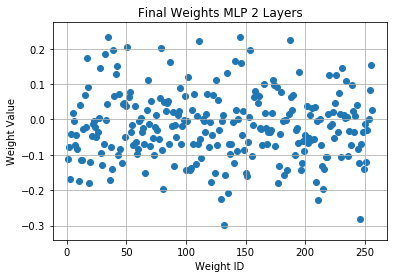

In [859]:
# Plot of all the Weights 
plt.scatter(wID, Wlist)
plt.title('Final Weights MLP 2 Layers')
plt.xlabel('Weight ID')
plt.ylabel('Weight Value')
plt.grid()
plt.show()

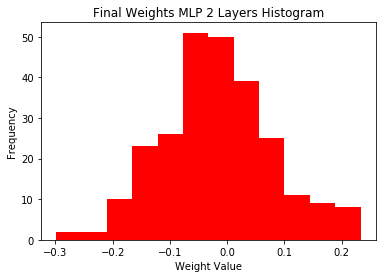

In [860]:
# Plot of all the Weights  Frequency
plt.hist(Wlist,  bins=12, facecolor='red',) #alpha = 0.1,
plt.title('Final Weights MLP 2 Layers Histogram')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
#plt.grid()
plt.show()